<a href="https://colab.research.google.com/github/samirasousza/RNA-2025.2-PP2.2/blob/main/PP2_2_3_Valida%C3%A7%C3%A3o_Cruzada_e_Busca_em_Grade_Eve_Sandra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Redes Neurais Artificiais 2025.2

- **Disciplina**: Redes Neurais Artificiais 2025.2
- **Professora**: Elloá B. Guedes (ebgcosta@uea.edu.br)  
- **Github**: http://github.com/elloa  
        

Levando em conta a base de dados **_Forest Cover Type_**, esta parte do Projeto Prático diz respeito à proposição e avaliação de múltiplas redes neurais artificiais do tipo feedforward multilayer perceptron para o problema da classificação multi-classe da cobertura florestal em uma área do Roosevelt National Forest.

## Busca em Grade

Uma maneira padrão de escolher os parâmetros de um modelo de Machine Learning é por meio de uma busca em grade via força bruta. O algoritmo da busca em grade é dado como segue:

1. Escolha a métrica de desempenho que você deseja maximizar  
2. Escolha o algoritmo de Machine Learning (exemplo: redes neurais artificiais). Em seguida, defina os parâmetros ou hiperparâmetros deste tipo de modelo sobre os quais você dseja otimizar (número de épocas, taxa de aprendizado, etc.) e construa um array de valores a serem testados para cada parâmetro ou hiperparâmetro.  
3. Defina a grade de busca, a qual é dada como o produto cartesiano de cada parâmetro a ser testado. Por exemplo, para os arrays [50, 100, 1000] e [10, 15], tem-se que a grade é [(50,10), (50,15), (100,10), (100,15), (1000,10), (1000,15)].
4. Para cada combinação de parâmetros a serem otimizados, utilize o conjunto de treinamento para realizar uma validação cruzada (holdout ou k-fold) e calcule a métrica de avaliação no conjunto de teste (ou conjuntos de teste)
5. Escolha a combinação de parâmetros que maximizam a métrica de avaliação. Este é o modelo otimizado.

Por que esta abordagem funciona? Porque a busca em grade efetua uma pesquisa extensiva sobre as possíveis combinações de valores para cada um dos parâmetros a serem ajustados. Para cada combinação, ela estima a performance do modelo em dados novos. Por fim, o modelo com melhor métrica de desempenho é escolhido. Tem-se então que este modelo é o que melhor pode vir a generalizar mediante dados nunca antes vistos.

## Efetuando a Busca em Grade sobre Hiperparâmetros das Top-6 RNAs

Considerando a etapa anterior do projeto prático, foram identificadas pelo menos 6 melhores Redes Neurais para o problema da classificação multi-classe da cobertura florestal no conjunto de dados selecionado. Algumas destas redes possuem atributos categóricos como variáveis preditoras, enquanto outras possuem apenas os atributos numéricos como preditores.

A primeira etapa desta segunda parte do projeto consiste em trazer para este notebook estas seis arquiteturas, ressaltando:

1. Número de neurônios ocultos por camada  
2. Função de Ativação  
3. Utilização ou não de atributos categóricos   
4. Desempenho médio +- desvio padrão nos testes anteriores  
5. Número de repetições que a equipe conseguiu realizar para verificar os resultados  

Elabore uma busca em grade sobre estas arquiteturas que contemple variações nos hiperparâmetros a seguir, conforme documentação de [MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

A. Solver  (Não usar o LBFGS, pois é mais adequado para datasets pequenos)  
B. Batch Size  
C. Learning Rate Init  
D. Paciência (n_iter_no_change)  
E. Épocas  

Nesta busca em grande, contemple a utilização do objeto [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

## Validação Cruzada k-fold

Na elaboração da busca em grid, vamos avaliar os modelos propostos segundo uma estratégia de validação cruzada ainda não explorada até o momento: a validação cruzada k-fold. Segundo a mesma, o conjunto de dados é particionado em k partes: a cada iteração, separa-se uma das partes para teste e o modelo é treinado com as k-1 partes remanescentes. Valores sugestivos de k na literatura são k = 3, 5 ou 10, pois o custo computacional desta validação dos modelos é alto. A métrica de desempenho é resultante da média dos desempenhos nas k iterações. A figura a seguir ilustra a ideia desta avaliação

<img src = "https://ethen8181.github.io/machine-learning/model_selection/img/kfolds.png" width=600></img>

Considerando a métrica de desempenho F1-Score, considere a validação cruzada 5-fold para aferir os resultados da busca em grande anterior.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix, ConfusionMatrixDisplay
from joblib import Parallel, delayed, dump, load
import matplotlib.pyplot as plt
import kagglehub
import warnings
warnings.filterwarnings("ignore")

In [ ]:
path = kagglehub.dataset_download("uciml/forest-cover-type-dataset")
df = pd.read_csv(f"{path}/covtype.csv")

print("Dataset shape:", df.shape)

y = df["Cover_Type"]
X = df.drop("Cover_Type", axis=1)

Dataset shape: (581012, 55)


In [ ]:
num_cols = [
    "Elevation", "Aspect", "Slope", "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Roadways",
    "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points"
]
cat_cols = [col for col in X.columns if col not in num_cols]

In [ ]:

def standardScale(df, X_train, X_test):
    X_train_stand = X_train.copy()
    X_test_stand = X_test.copy()
    num_cols = df.columns[:-1]
    for i in num_cols:
        scale = StandardScaler().fit(X_train_stand[[i]])
        X_train_stand[i] = scale.transform(X_train_stand[[i]])
        X_test_stand[i] = scale.transform(X_test_stand[[i]])
    return X_train_stand, X_test_stand

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("passthrough", "passthrough")
])

preprocessor_numeric = ColumnTransformer(
    transformers=[("num", numeric_transformer, num_cols)]
)

preprocessor_categorical = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)

In [ ]:
architectures = [
    {"desc": "Categorical, hidden (4,2), α=0.5, relu",
     "preproc": preprocessor_categorical, "hidden_layer_sizes": (4), "activation": "relu", "alpha": 0.5},

    {"desc": "Numeric, hidden (16,7), α=2.0, relu",
     "preproc": preprocessor_numeric, "hidden_layer_sizes": (16), "activation": "relu", "alpha": 2.0},

    {"desc": "Categorical, hidden (25,1), α=3.0, relu",
     "preproc": preprocessor_categorical, "hidden_layer_sizes": (25), "activation": "relu", "alpha": 3.0},

    {"desc": "Numeric, hidden (8,4), tanh",
     "preproc": preprocessor_numeric, "hidden_layer_sizes": (8, 4), "activation": "tanh", "alpha": 0.0001},

    {"desc": "Numeric, hidden (8,4), relu",
     "preproc": preprocessor_numeric, "hidden_layer_sizes": (8, 4), "activation": "relu", "alpha": 0.0001},

    {"desc": "Numeric, hidden (8,), logistic",
     "preproc": preprocessor_numeric, "hidden_layer_sizes": (8,), "activation": "logistic", "alpha": 0.0001},
]

param_grid = {
    "mlp__solver": ["adam", "sgd"],
    "mlp__batch_size": [32, 64],
    "mlp__learning_rate_init": [0.001, 0.01],
    "mlp__n_iter_no_change": [5, 10],
    "mlp__max_iter": [100, 200]
}

In [ ]:
results_summary = []
results_all = []

def run_grid_search(arch, X_train, y_train, X_test, y_test, param_grid):
    print(f"\n=== Running architecture: {arch['desc']} ===")

    pipeline = Pipeline(steps=[
        ("preprocessor", arch["preproc"]),
        ("mlp", MLPClassifier(
            hidden_layer_sizes=arch["hidden_layer_sizes"],
            activation=arch["activation"],
            alpha=arch["alpha"],
            random_state=42
        ))
    ])

    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring="accuracy",
        n_jobs=-1,
        cv=3,
        verbose=0,
        return_train_score=True
    )

    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_train_pred = best_model.predict(X_train)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    train_acc = accuracy_score(y_train, y_train_pred)
    train_f1 = f1_score(y_train, y_train_pred, average='weighted')

    summary = {
        "Architecture": arch["desc"],
        "Best Parameters": grid_search.best_params_,
        "Mean CV Accuracy": grid_search.best_score_,
        "Test Accuracy": acc,
        "Test F1-score": f1,
        "Train Accuracy": train_acc,
        "Train F1-score": train_f1
    }

    df_all = pd.DataFrame(grid_search.cv_results_)
    df_all["Architecture"] = arch["desc"]

    dump(summary, f"grid_summary_{arch['desc'].replace(' ', '_')}.joblib")
    dump(df_all, f"grid_all_results_{arch['desc'].replace(' ', '_')}.joblib")

    return summary, df_all

results = Parallel(n_jobs=4)(
    delayed(run_grid_search)(arch, X_train, y_train, X_test, y_test, param_grid)
    for arch in architectures
)

results_summary = [r[0] for r in results]
results_all = [r[1] for r in results]

df_best = pd.DataFrame(results_summary)

df_all = pd.concat(results_all, ignore_index=True)

print("\n===== Best Parameters Summary =====")
print(df_best)

print("\n===== All Grid Search Results =====")
print(df_all[["Architecture", "params", "mean_test_score", "std_test_score", "mean_train_score"]])

print("\n===== Test Results with F1-score =====")
print(df_best[["Architecture", "Test Accuracy", "Test F1-score", "Train Accuracy", "Train F1-score"]])


/home/evelynbessa/Downloads/uea/mlprun/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/evelynbessa/Downloads/uea/mlprun/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/evelynbessa/Downloads/uea/mlprun/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/evelynbessa/Downloads/uea/mlprun/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't conv


=== Running architecture: Categorical, hidden (25,1), α=3.0, relu ===


/home/evelynbessa/Downloads/uea/mlprun/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/evelynbessa/Downloads/uea/mlprun/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/evelynbessa/Downloads/uea/mlprun/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/evelynbessa/Downloads/uea/mlprun/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't conv


=== Running architecture: Numeric, hidden (8,4), tanh ===


/home/evelynbessa/Downloads/uea/mlprun/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/evelynbessa/Downloads/uea/mlprun/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/evelynbessa/Downloads/uea/mlprun/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



=== Running architecture: Numeric, hidden (16,7), α=2.0, relu ===

=== Running architecture: Numeric, hidden (8,4), relu ===

=== Running architecture: Categorical, hidden (4,2), α=0.5, relu ===

=== Running architecture: Numeric, hidden (8,), logistic ===

===== Best Parameters Summary =====
                              Architecture  \
0   Categorical, hidden (4,2), α=0.5, relu   
1      Numeric, hidden (16,7), α=2.0, relu   
2  Categorical, hidden (25,1), α=3.0, relu   
3              Numeric, hidden (8,4), tanh   
4              Numeric, hidden (8,4), relu   
5           Numeric, hidden (8,), logistic   

                                     Best Parameters  Mean CV Accuracy  \
0  {'mlp__batch_size': 64, 'mlp__learning_rate_in...          0.713979   
1  {'mlp__batch_size': 64, 'mlp__learning_rate_in...          0.686957   
2  {'mlp__batch_size': 64, 'mlp__learning_rate_in...          0.688258   
3  {'mlp__batch_size': 32, 'mlp__learning_rate_in...          0.728336   
4  {'mlp__ba

In [ ]:
results_summary = [r[0] for r in results]
results_all = [r[1] for r in results]

df_best = pd.DataFrame(results_summary)

df_all = pd.concat(results_all, ignore_index=True)

print("\n===== Best Parameters Summary =====")
print(df_best)

print("\n===== All Grid Search Results =====")
print(df_all[["Architecture", "params", "mean_test_score", "std_test_score", "mean_train_score"]])

print("\n===== Test Results with F1-score =====")
print(df_best[["Architecture", "Test Accuracy", "Test F1-score", "Train Accuracy", "Train F1-score"]])


===== Best Parameters Summary =====
                              Architecture  \
0   Categorical, hidden (4,2), α=0.5, relu   
1      Numeric, hidden (16,7), α=2.0, relu   
2  Categorical, hidden (25,1), α=3.0, relu   
3              Numeric, hidden (8,4), tanh   
4              Numeric, hidden (8,4), relu   
5           Numeric, hidden (8,), logistic   

                                     Best Parameters  Mean CV Accuracy  \
0  {'mlp__batch_size': 64, 'mlp__learning_rate_in...          0.713979   
1  {'mlp__batch_size': 64, 'mlp__learning_rate_in...          0.686957   
2  {'mlp__batch_size': 64, 'mlp__learning_rate_in...          0.688258   
3  {'mlp__batch_size': 32, 'mlp__learning_rate_in...          0.728336   
4  {'mlp__batch_size': 32, 'mlp__learning_rate_in...          0.717844   
5  {'mlp__batch_size': 64, 'mlp__learning_rate_in...          0.717426   

   Test Accuracy  Test F1-score  Train Accuracy  Train F1-score  
0       0.714545       0.694804        0.714395        

## Identificando a mellhor solução

Como resultado da busca em grande com validação cruzada 5-fold, identifique o modelo otimizado com melhor desempenho para o problema. Apresente claramente este modelo, seus parâmetros, hiperparâmetros otimizados e resultados para cada um dos folds avaliados. Esta é a melhor solução identificada em decorrência deste projeto

O modelo com os parâmetros e resultados que mais se destacou dentre os demais, está exibido abaixo nesta tabela. (Obs: devido a grande quantidade de poder computacional exigida, foi feito somente validação cruzada 3-fold).

In [ ]:
from pprint import pprint
df_best_ = pd.DataFrame(results_summary.copy())

df_best_sorted = df_best_.sort_values(by=["Test Accuracy", "Test F1-score"], ascending=[False, False])

best_model_ = df_best_sorted.iloc[0]

print("\n===== Best Neural Network (Test Accuracy e Test F1-score) =====")
print(best_model_[["Architecture", "Mean CV Accuracy", "Test Accuracy", "Test F1-score", "Train Accuracy", "Train F1-score"]])
print("Best Parameters:")
pprint(best_model_["Best Parameters"], indent=38)


===== Best Neural Network (Test Accuracy e Test F1-score) =====
Architecture        Numeric, hidden (8,4), tanh
Mean CV Accuracy                       0.728336
Test Accuracy                          0.723977
Test F1-score                           0.71307
Train Accuracy                         0.723738
Train F1-score                         0.712788
Name: 3, dtype: object
Best Parameters:
{                                     'mlp__batch_size': 32,
                                      'mlp__learning_rate_init': 0.001,
                                      'mlp__max_iter': 200,
                                      'mlp__n_iter_no_change': 10,
                                      'mlp__solver': 'adam'}


## Empacotando a solução

Suponha que você deve entregar este classificador ao órgão responsável por administrar o Roosevelt National Park. Para tanto, você deve fazer uma preparação do mesmo para utilização neste cenário. Uma vez que já identificou os melhores parâmetros e hiperparâmetros, o passo remanescente consiste em treinar o modelo com estes valores e todos os dados disponíveis, salvando o conjunto de pesos do modelo ao final para entrega ao cliente. Assim, finalize o projeto prático realizando tais passos.

1. Consulte a documentação a seguir:
https://scikit-learn.org/stable/modules/model_persistence.html  
2. Treine o modelo com todos os dados  
3. Salve o modelo em disco  
4. Construa uma rotina que recupere o modelo em disco  
5. Mostre que a rotina é funcional, fazendo previsões com todos os elementos do dataset e exibindo uma matriz de confusão das mesmas

In [ ]:
path = kagglehub.dataset_download("uciml/forest-cover-type-dataset")
df = pd.read_csv(f"{path}/covtype.csv")
print("Dataset shape:", df.shape)

y = df["Cover_Type"]
X = df.drop("Cover_Type", axis=1)

num_cols = X.columns

Dataset shape: (581012, 55)


In [ ]:
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

preprocessor_final = ColumnTransformer(
    transformers=[("num", numeric_transformer, num_cols)]
)

best_params = {
    'hidden_layer_sizes': (8, 4),
    'activation': 'tanh',
    'solver': 'adam',
    'batch_size': 32,
    'learning_rate_init': 0.001,
    'max_iter': 200,
    'n_iter_no_change': 10,
    'random_state': 42
}

In [ ]:
def train_final_model(X, y):
    final_model = Pipeline(steps=[
        ("preprocessor", preprocessor_final),
        ("mlp", MLPClassifier(**best_params))
    ])
    final_model.fit(X, y)
    return final_model

In [ ]:
models = Parallel(n_jobs=-1, verbose=10)(
    [delayed(train_final_model)(X, y)]
)

final_model = models[0]
dump(final_model, "final_mlp_model.joblib")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 1 out of 1 | elapsed:  7.5min


['final_mlp_model.joblib']

In [ ]:
# Loading saved models with joblib and predict

loaded_model = load("final_mlp_model.joblib")

y_pred_full = loaded_model.predict(X)

f1_final = f1_score(y, y_pred_full, average='weighted')
print(f"\n Final F1-score: {f1_final:.4f}")


 Final F1-score: 0.7470


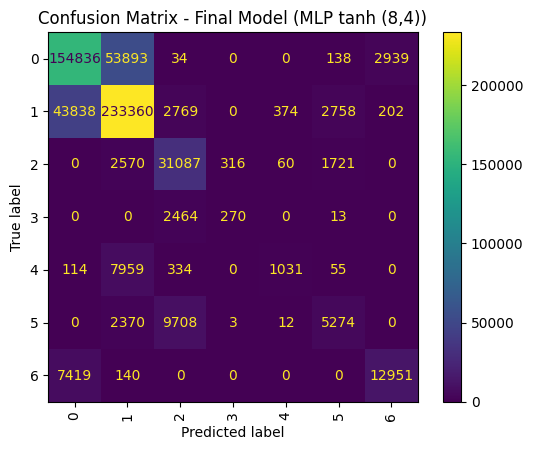

In [ ]:
cm = confusion_matrix(y, y_pred_full)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="viridis", xticks_rotation="vertical")
plt.title("Confusion Matrix - Final Model (MLP tanh (8,4))")
plt.show()